In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
# Load the dataset
df = pd.read_csv('../Data/pre_ADA-USD.csv')
# data = df['Close'].values.reshape(-1, 1)

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Days_Since_Start
0,0.311973,0.311973,0.288392,0.304397,0.304397,184691008,0
1,0.304424,0.307058,0.288875,0.293504,0.293504,107240000,1
2,0.292952,0.309129,0.292507,0.297106,0.297106,115320000,2
3,0.296285,0.303588,0.286193,0.300787,0.300787,94436000,3
4,0.299897,0.317723,0.291055,0.297622,0.297622,202675008,4


In [9]:
df= df.drop(columns=["Open", "High", "Low", "Adj Close","Volume"])
df = df.rename(columns={'Close': 'Price'})
df = pd.DataFrame(data=df)
data = df

In [10]:
#data["Price"]=data["Price"]*100

In [11]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train, test = data.iloc[:split_index], data.iloc[split_index:]

In [12]:
def forecast_arima(train, steps):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def forecast_linear_regression(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = LinearRegression()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

def forecast_decision_tree(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = DecisionTreeRegressor()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

In [13]:
# Train models and forecast for training set
arima_train_forecast = forecast_arima(train['Price'], len(train))
lr_train_forecast = forecast_linear_regression(train, len(train))
dt_train_forecast = forecast_decision_tree(train, len(train))

In [14]:
arima_train_forecast

1828    0.351686
1829    0.350623
1830    0.351387
1831    0.350838
1832    0.351232
          ...   
3651    0.351067
3652    0.351067
3653    0.351067
3654    0.351067
3655    0.351067
Name: predicted_mean, Length: 1828, dtype: float64

In [15]:
train['Price']

0       0.304397
1       0.293504
2       0.297106
3       0.300787
4       0.297622
          ...   
1823    0.368973
1824    0.364899
1825    0.352454
1826    0.360356
1827    0.350206
Name: Price, Length: 1828, dtype: float64

In [16]:
arima_train_forecast.index = train['Price'].index

In [17]:
# Calculate errors for training forecasts
errors_arima = train['Price'] - arima_train_forecast
errors_lr = train['Price'] - lr_train_forecast
errors_dt = train['Price'] - dt_train_forecast

In [18]:
print(errors_arima.describe())

count    1828.000000
mean        0.140534
std         0.629235
min        -0.327106
25%        -0.285962
50%        -0.190834
75%         0.284026
max         2.617172
dtype: float64


In [19]:
# Adjust forecasts using AR process for each model based on training errors
adjusted_arima_model = AutoReg(errors_arima, lags=1).fit()
adjusted_lr_model = AutoReg(errors_lr, lags=1).fit()
adjusted_dt_model = AutoReg(errors_dt, lags=1).fit()

In [20]:
len(errors_arima) + len(test) - 1

2284

In [21]:
# Forecast for test set using adjusted models
adjusted_forecasts_arima = arima_train_forecast.iloc[-1] + adjusted_arima_model.predict(start=len(errors_arima), end=len(errors_arima) + len(test) - 1)
adjusted_forecasts_lr = lr_train_forecast[-1] + adjusted_lr_model.predict(start=len(errors_lr), end=len(errors_lr) + len(test) - 1)
adjusted_forecasts_dt = dt_train_forecast[-1] + adjusted_dt_model.predict(start=len(errors_dt), end=len(errors_dt) + len(test) - 1)


In [22]:
# Combine adjusted forecasts for test set
adjusted_forecasts_combined = np.mean([adjusted_forecasts_arima, adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)
# adjusted_forecasts_combined = np.mean([adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)

In [23]:

# Tính các chỉ số đánh giá MAE, MSE, MAPE
mae = mean_absolute_error(test['Price'], adjusted_forecasts_combined)
mse = mean_squared_error(test['Price'], adjusted_forecasts_combined)
mape = np.mean(np.abs((test['Price'].values - adjusted_forecasts_combined) / test['Price'].values)) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')

MAE: 0.1078640075532546
MSE: 0.01703419171321899
MAPE: 32.38386793841121%


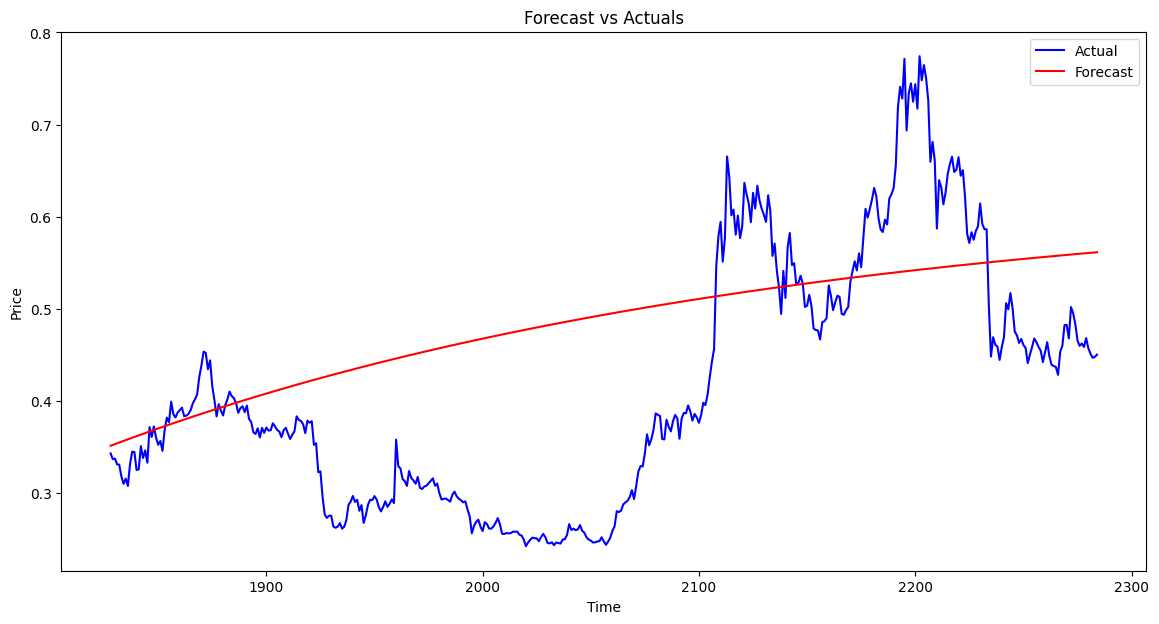

In [24]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Price'], label='Actual', color='blue')
plt.plot(test.index, adjusted_forecasts_combined, label='Forecast', color='red')
plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Forecast in all data 

In [25]:
# Forecast for test set using adjusted models
adjusted_forecasts_arima = arima_train_forecast.iloc[-1] + adjusted_arima_model.predict(start=0, end=len(errors_arima) + len(test) - 1)
adjusted_forecasts_lr = lr_train_forecast[-1] + adjusted_lr_model.predict(start=0, end=len(errors_lr) + len(test) - 1)
adjusted_forecasts_dt = dt_train_forecast[-1] + adjusted_dt_model.predict(start=0, end=len(errors_dt) + len(test) - 1)

In [26]:
adjusted_forecasts_combined = np.mean([adjusted_forecasts_arima, adjusted_forecasts_lr, adjusted_forecasts_dt], axis=0)

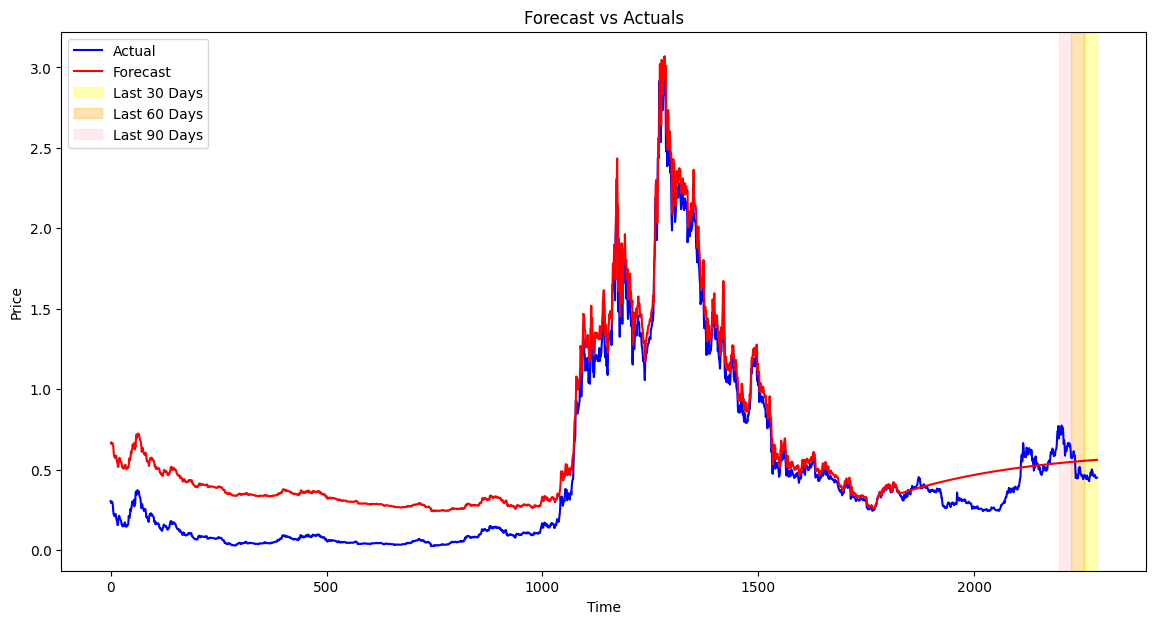

In [27]:
# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Price'], label='Actual', color='blue')
plt.plot(data.index, adjusted_forecasts_combined, label='Forecast', color='red')

# Highlight the last 30, 60, 90 days predictions
plt.axvspan(test.index[-30], test.index[-1], color='yellow', alpha=0.3, label='Last 30 Days')
plt.axvspan(test.index[-60], test.index[-30], color='orange', alpha=0.3, label='Last 60 Days')
plt.axvspan(test.index[-90], test.index[-60], color='pink', alpha=0.3, label='Last 90 Days')


plt.title('Forecast vs Actuals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Use 3 statsmodel